# Predicting User Ad Interactions with TensorFlow

This project focuses on **predicting user interactions with online advertisements**.  
Specifically, it aims to model and predict three key outcomes:  
- **label_view**: whether the user will view the ad  
- **label_click**: whether the user will click on the ad  
- **label_landing**: whether the user will land on the advertiser’s website or complete a purchase  

Accurately predicting these outcomes is crucial in the **ad placement pipeline**.  
By estimating the probability of each event, platforms can:  
- Select the most relevant ads for each user  
- Optimize advertising revenue  
- Improve user experience by showing more meaningful ads  

The models are built using **TensorFlow/Keras** and trained on a dataset of user interactions.  
We explore how different preprocessing steps, architectures, and evaluation metrics affect model performance.  

The notebook is structured as follows:
1. Data Loading and Exploration  
2. Preprocessing and Feature Engineering  
3. Model Building, Training, and Evaluation.
   
    3-1- Model1
   
    3-2- Model2
5. Results and discussion


In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import numpy as np
tf.random.set_seed(150)
%load_ext tensorboard


## 1. Data Loading and Initial Exploration

We start by importing the dataset and inspecting its structure.  
Key steps:
- Check dataset dimensions  
- Display sample rows  
- Identify data types and missing values  

The goal here is to understand what we’re working with before preprocessing.


#### Loading data

In [2]:
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")
df_test.columns=df_train.columns

#### Data info

In [3]:
n_samples=len(df_train)
print(n_samples)
print(df_train.head())
print(df_train.info())
print(df_train.describe())
print(df_train.nunique().sort_values(ascending=False))

6999999
   label_view  label_click  label_landing    fea01    fea02    fea03    fea04  \
0           1            1              1  1308589  5249024  1241777  6956213   
1           1            1              1  2640944  7786541  5575117  2708373   
2           1            1              0  6394000  4429313  1887597  5672300   
3           1            1              1  3966143   588020  4030883  6483087   
4           1            1              1  5964079  1033999  5899315  2081891   

     fea05    fea06    fea07  ...    fea34    fea35    fea36    fea37  \
0  2662575  6512986  3253736  ...  6862304  2051752  6627946  5838950   
1  3034200  4878984  3730545  ...  6862304   765266  4232371  5110684   
2   756205  1310599  3109273  ...  6862304  7524740  3589060  3442506   
3  4036638  7673284  6579668  ...  6862304  3004649  6627946  7048743   
4  3603520  2880164   514795  ...  6862304  2051752  6627946  5838950   

     fea38    fea39    fea40    fea41    fea42    fea43  
0  43453

## 2. Preprocessing and Feature Engineering

Before training models, we need to prepare the dataset.  
This includes:
- Handling missing values  
- Encoding categorical features  
- Normalizing/standardizing numerical variables  
- Splitting the dataset into training, validation, and test sets  

Proper preprocessing ensures the neural network can learn effectively.


#### Feature selection and preparation


In [4]:
def determine_n_factors_conserv(cardinality):
    return int(np.ceil(np.log(cardinality)))
def determine_n_factors_brutal(cardinality):
    return 1 if cardinality<10000 else 2
def determine_n_factors(cardinality):
    return int(min(70,6*(cardinality)**0.25))
features=df_train.drop(columns=['label_click','label_landing','label_view'])
test_features=df_test.drop(columns=['label_click','label_landing','label_view'])
#features.info()
n_features=len(features.columns)

encoded_features_hc=pd.DataFrame()
encoded_features_lc=pd.DataFrame()
#
test_encoded_features_hc=pd.DataFrame()
test_encoded_features_lc=pd.DataFrame()
#
feature_card={}
# separate features according to cardinality -> use embedding only for high cardinality
for col in features.columns:
    unique_elements=features[col].unique()
    n_unique=len(unique_elements)

    feature_card[col]=n_unique
    num_encoding={x:i for i,x in enumerate(unique_elements)}
    if(n_unique>150): #tune this to avoid overfitting 
        encoded_features_hc[col]=features[col].map(num_encoding)
        test_encoded_features_hc[col]=df_test[col].map(num_encoding)
    else:
        encoded_features_lc[col]=features[col].map(num_encoding)
        test_encoded_features_lc[col]=df_test[col].map(num_encoding)
if(test_encoded_features_hc.isnull().values.any() or test_encoded_features_lc.isnull().values.any()):    # categories in test but not existing in training
    print("there are NA values in the test set")                                                         #I assumed that is from incorrect data sampling
    mask=~test_encoded_features_hc.isnull().any(axis=1) & ~test_encoded_features_lc.isnull().any(axis=1) #other wise I set it to zero instead of dropping-> loss of info
    test_encoded_features_hc=test_encoded_features_hc[mask]
    test_encoded_features_lc=test_encoded_features_lc[mask]
    encoded_features_hc = encoded_features_hc.astype('int32')
    encoded_features_lc = encoded_features_lc.astype('int32')
    if(not test_encoded_features_hc.isnull().values.any() and not test_encoded_features_lc.isnull().values.any()):
        print("corresponding rows removed successfully")
    df_test=df_test[mask]
n_features_hc=len(encoded_features_hc.columns)
n_features_lc=len(encoded_features_lc.columns)

n_feature_card=[feature_card[col] for col in encoded_features_hc.columns]
factors=[determine_n_factors_brutal(n) for n in n_feature_card]

there are NA values in the test set
corresponding rows removed successfully


## 3. Model Building and evaluation

I use TensorFlow/Keras to define models that predict each label (`label_view`, `label_click`, `label_landing`).  

Key design choices:
- Input layers reflect the preprocessed features  
- Hidden layers use nonlinear activations (e.g., ReLU)  
- Output layer depends on the prediction task (binary classification in this case)  

I experiment with different architectures and regularization methods.


#### useful functions

In [5]:
def build_input_layer_sparse(n_features): # for the high cardinality features
    result=[layers.Input(shape=(1,),dtype=tf.int32) for i in range(n_features)]
    return result
def build_input_layer_dense(n_features,sizes): # for the low cardinality featuers
    result=[layers.Input(shape=(sizes[i],),dtype=tf.int32) for i in range(n_features)]
    return result
def build_dnn(x,sizes,alpha=0.01):
    for size in sizes:
        layer=layers.Dense(size,activation='relu',kernel_regularizer=regularizers.l2(alpha))
        x=layer(x)
        x=layers.Dropout(0.4)(x)
    output=layers.Dense(1,activation='sigmoid',kernel_regularizer=regularizers.l2(alpha))(x)
    return output

Training and Evaluation

The models are trained using the training set and evaluated on validation/test data.  

I track:
- **Loss function** (binary crossentropy)  
- **Metrics** (accuracy, AUC, precision, recall, etc.)  

Training includes:
- Early stopping to prevent overfitting  
- Monitoring validation performance  
- Comparing models for different labels
I will show here two models along with evaluating and testing them.

### Model1
This model is wide and not very deep

In [ ]:
def build_wide_model(inputs_hc,inputs_lc,n_feature_card,factors,alpha):
    input_embd=[layers.Embedding(n_feature_card[i],factors[i])(inputs_hc[i]) for i in range(len(inputs_hc))] # very low factor embedding (1-2) factors to keep it simple
    input_embd=[layers.Flatten()(el) for el in input_embd]
    x=layers.Concatenate()(input_embd+inputs_lc) #shared layer
    output_view=layers.Dense(1,activation='sigmoid',kernel_regularizer=regularizers.l2(alpha),name='label_view')(x)
    x2=layers.Concatenate()([x,output_view]) #combine the output from view
    output_click=layers.Dense(1,activation='sigmoid',kernel_regularizer=regularizers.l2(alpha),name='label_click')(x2)
    x3=layers.Concatenate()([x2,output_view])# combine the output from click
    output_landing=layers.Dense(1,activation='sigmoid',kernel_regularizer=regularizers.l2(alpha),name='label_landing')(x3)
    return models.Model(inputs=[inputs_hc,inputs_lc],outputs=[output_view,output_click,output_landing])

In [7]:
alpha=0.1
lr=0.001
batch_size=60
inputs_hc=build_input_layer_sparse(n_features_hc)
sizes=[feature_card[col] for col in encoded_features_lc.columns]
inputs_lc=build_input_layer_dense(n_features_lc,sizes)

wide_model=build_wide_model(inputs_hc,inputs_lc,n_feature_card,factors,alpha)
wide_model.compile(optimizer=keras.optimizers.Adam(lr),    
        loss={'label_click': 'binary_crossentropy',
          'label_landing': 'binary_crossentropy',
          'label_view': 'binary_crossentropy'},
         metrics={'label_click': 'AUC',
             'label_landing': 'AUC',
             'label_view': 'AUC'}
                    )
wide_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 1)         │          0 │ -               

 Total params: 2,418,338 (9.23 MB)

 Trainable params: 2,418,338 (9.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
plot_model(wide_model,show_shapes=True, show_dtype=True,show_layer_activations=True,show_trainable=False,dpi=60)

##### Training the model

In [8]:
#train the model
callbacks=[keras.callbacks.EarlyStopping(monitor='val_label_landing_AUC',mode='max',min_delta=1e-3,patience=1,verbose=1),keras.callbacks.TensorBoard(log_dir='log_wide_model')]
inputs_hc=[encoded_features_hc[col].values[:int(n_samples/20)] for col in encoded_features_hc.columns]
inputs_lc= [tf.one_hot(encoded_features_lc[col], depth=feature_card[col]).numpy() for col in encoded_features_lc.columns]
inputs=[inputs_hc,inputs_lc]

y = {
    'label_click': df_train.loc[:int(n_samples/20),"label_click"].values,
    'label_landing': df_train.loc[:int(n_samples/20),"label_landing"].values,
    'label_view': df_train.loc[:int(n_samples/20),"label_view"].values
}

history = wide_model.fit(
    inputs,  
    y,           
    batch_size=batch_size,
    epochs=8,
    validation_split=0.2,  
    verbose=1,
    callbacks=callbacks
)

Epoch 1/8
4667/4667 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - label_click_AUC: 0.7591 - label_click_loss: 0.5347 - label_landing_AUC: 0.7214 - label_landing_loss: 0.5161 - label_view_AUC: 0.7671 - label_view_loss: 0.5847 - loss: 1.7281 - val_label_click_AUC: 0.7429 - val_label_click_loss: 0.4918 - val_label_landing_AUC: 0.7295 - val_label_landing_loss: 0.4512 - val_label_view_AUC: 0.7780 - val_label_view_loss: 0.6000 - val_loss: 1.6076
Epoch 2/8
4667/4667 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - label_click_AUC: 0.8169 - label_click_loss: 0.4786 - label_landing_AUC: 0.7935 - label_landing_loss: 0.4626 - label_view_AUC: 0.8339 - label_view_loss: 0.5054 - loss: 1.5104 - val_label_click_AUC: 0.7521 - val_label_click_loss: 0.4818 - val_label_landing_AUC: 0.7359 - val_label_landing_loss: 0.4430 - val_label_view_AUC: 0.7884 - val_label_view_loss: 0.5861 - val_loss: 1.5654
Epoch 3/8
4667/4667 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - label_click_AUC: 0.8245 - label_click_loss: 0.4685 - label_landing_AUC: 0.80

In [ ]:
%tensorboard --logdir log_wide_model --reuse_port=True

##### Testing the model

In [10]:
#testing
test_inputs_hc=[test_encoded_features_hc[col].values for col in test_encoded_features_hc.columns]
test_inputs_lc= [tf.one_hot(test_encoded_features_lc[col], depth=feature_card[col]).numpy() for col in test_encoded_features_lc.columns]
test_inputs=[test_inputs_hc,test_inputs_lc]
y = {
    'label_click': df_test["label_click"].values,
    'label_landing': df_test["label_landing"].values,
    'label_view': df_test["label_view"].values
}
result=wide_model.evaluate(test_inputs,y)

64602/64602 ━━━━━━━━━━━━━━━━━━━━ 105s 2ms/step - label_click_AUC: 0.7434 - label_click_loss: 0.4672 - label_landing_AUC: 0.7370 - label_landing_loss: 0.4338 - label_view_AUC: 0.7963 - label_view_loss: 0.5476 - loss: 1.5273


### Model2
This model is deep and wide.

##### Preparing the model

In [6]:
def build_deep_model(inputs_hc,inputs_lc,n_feature_card,factors,sizes,alpha):
    input_embd=[layers.Embedding(n_feature_card[i],factors[i])(inputs_hc[i]) for i in range(len(inputs_hc))] #embedding layer for high cardinality features
    input_embd=[layers.Flatten()(el) for el in input_embd]
    x=layers.Concatenate()(input_embd+inputs_lc) # the shared layer
    
    y=build_dnn(x,sizes,alpha=alpha) #deep layer for view
    yx=layers.Concatenate()([y,x]) # deep and wide
    logit_view = layers.Dense(1,kernel_regularizer=regularizers.l2(alpha))(yx) # save before the sigmoid activation to feed to the click prediction
    output_view=layers.Activation('sigmoid', name='label_view')(logit_view) #apply the activation

    y2=build_dnn(x,sizes,alpha=alpha) #deep layer for click
    yx2=layers.Concatenate()([y,x,logit_view]) #include the output from view (someone who clicks, probably has viewed!)
    logit_click=layers.Dense(1,kernel_regularizer=regularizers.l2(alpha))(yx2)
    output_click=layers.Activation('sigmoid',name='label_click')(logit_click)

    y3=build_dnn(x,sizes,alpha=alpha) #deep layer for land
    yx3=layers.Concatenate()([y3,x,logit_click])# again include the output from click
    output_landing=layers.Dense(1,activation='sigmoid',kernel_regularizer=regularizers.l2(alpha),name='label_landing')(yx3)
    return models.Model(inputs=[inputs_hc,inputs_lc],outputs=[output_view,output_click,output_landing])

In [7]:
alpha=0.05 # tuned to correct overfitting
lr=0.0005 # larger lr leads to less stable learning
batch_size=60 #ignored
inputs_hc=build_input_layer_sparse(n_features_hc)
sizes=[feature_card[col] for col in encoded_features_lc.columns]
inputs_lc=build_input_layer_dense(n_features_lc,sizes)
factors2=[determine_n_factors_conserv(n) for n in n_feature_card]

layer_sizes=[60,20] # larger sizes contributed to overfitting
deep_model=build_deep_model(inputs_hc,inputs_lc,n_feature_card,factors2,layer_sizes,alpha)
deep_model.compile(optimizer=keras.optimizers.Adam(lr),    
        loss={'label_click': 'binary_crossentropy',
          'label_landing': 'binary_crossentropy',
          'label_view': 'binary_crossentropy'},
         metrics={'label_click': 'AUC',
             'label_landing': 'AUC',
             'label_view': 'AUC'}
                    )
deep_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 1)         │          0 │ -               

 Total params: 15,301,917 (58.37 MB)

 Trainable params: 15,301,917 (58.37 MB)

 Non-trainable params: 0 (0.00 B)

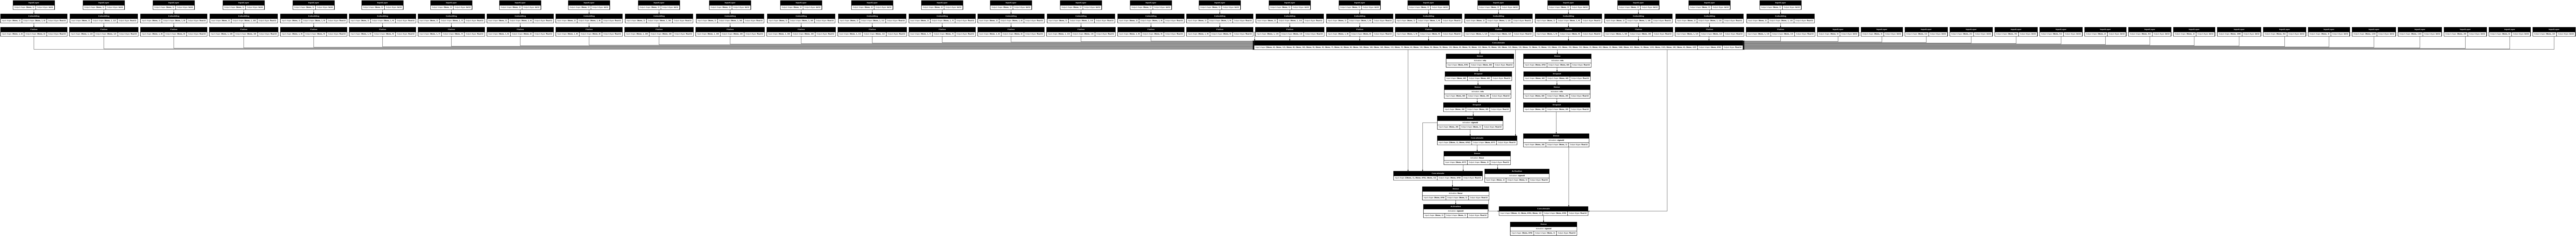

In [10]:
plot_model(deep_model,show_shapes=True, show_dtype=True,show_layer_activations=True,show_trainable=False,dpi=60)

##### Training the model

I train the model and finetune the hyperparameters by hand (on a smaller sample) before applying it on the full dataset. Ideally I would have done a grid-search to decrease over-fitting further

In [8]:
#train the model
callbacks=[keras.callbacks.EarlyStopping(monitor='val_label_landing_AUC',mode='max',min_delta=2e-3,patience=2,verbose=1),keras.callbacks.TensorBoard(log_dir='log_deep_model')]
inputs_hc=[encoded_features_hc[col].values[:int(n_samples)] for col in encoded_features_hc.columns]
inputs_lc= [tf.one_hot(encoded_features_lc.loc[:int(n_samples),col], depth=feature_card[col]).numpy() for col in encoded_features_lc.columns]
inputs=[inputs_hc,inputs_lc]

y = {
    'label_click': df_train.loc[:int(n_samples),"label_click"].values,
    'label_landing': df_train.loc[:int(n_samples),"label_landing"].values,
    'label_view': df_train.loc[:int(n_samples),"label_view"].values
}

history = deep_model.fit(
    inputs,  
    y,           
    batch_size=128,
    epochs=20,
    validation_split=0.2,  
    verbose=1,
    callbacks=callbacks
)

Epoch 1/20
43750/43750 ━━━━━━━━━━━━━━━━━━━━ 529s 12ms/step - label_click_AUC: 0.8098 - label_click_loss: 0.4446 - label_landing_AUC: 0.7909 - label_landing_loss: 0.4240 - label_view_AUC: 0.8135 - label_view_loss: 0.5297 - loss: 1.6207 - val_label_click_AUC: 0.8106 - val_label_click_loss: 0.4526 - val_label_landing_AUC: 0.7908 - val_label_landing_loss: 0.4317 - val_label_view_AUC: 0.8323 - val_label_view_loss: 0.5015 - val_loss: 1.4121
Epoch 2/20
43750/43750 ━━━━━━━━━━━━━━━━━━━━ 514s 12ms/step - label_click_AUC: 0.8328 - label_click_loss: 0.4218 - label_landing_AUC: 0.8165 - label_landing_loss: 0.4029 - label_view_AUC: 0.8374 - label_view_loss: 0.4968 - loss: 1.3465 - val_label_click_AUC: 0.8129 - val_label_click_loss: 0.4502 - val_label_landing_AUC: 0.7933 - val_label_landing_loss: 0.4295 - val_label_view_AUC: 0.8342 - val_label_view_loss: 0.4984 - val_loss: 1.4036
Epoch 3/20
43750/43750 ━━━━━━━━━━━━━━━━━━━━ 523s 12ms/step - label_click_AUC: 0.8409 - label_click_loss: 0.4133 - label_la

In [ ]:
%tensorboard --logdir log_deep_model --reuse_port=True

##### Testing the model

In [9]:
#testing
test_inputs_hc=[test_encoded_features_hc[col].values for col in test_encoded_features_hc.columns]
test_inputs_lc= [tf.one_hot(test_encoded_features_lc[col], depth=feature_card[col]).numpy() for col in test_encoded_features_lc.columns]
test_inputs=[test_inputs_hc,test_inputs_lc]
y = {
    'label_click': df_test["label_click"].values,
    'label_landing': df_test["label_landing"].values,
    'label_view': df_test["label_view"].values
}
result=deep_model.evaluate(test_inputs,y)

64602/64602 ━━━━━━━━━━━━━━━━━━━━ 117s 2ms/step - label_click_AUC: 0.8093 - label_click_loss: 0.4080 - label_landing_AUC: 0.8020 - label_landing_loss: 0.3854 - label_view_AUC: 0.8222 - label_view_loss: 0.5129 - loss: 1.3387


The model shows signs of over fitting-> making the model simpler (decreasing the size of layers and embeddings), decreasing learning rate and batch size, and removing some features all together would probably help , but I didn't have the time to do that

## Results
The second model produces results with an AUC at around 0.8. More accuratly:
-label view: 0.82
- label click: 0.81
- label landing:0.8
  
The evaluation during the training, shows signs of overfitting: The model stops improving on the evaluation sub-set within a few epochs even though it steadily improves on the training sub-set. This indicates that a reduction in model complexity could produce more favourable results.
I experimented with adding noise, lowering the learning rate, and modifying the model alittle. But a more rigorous grid-search over the parameters and a more aggressive model simplification would likely give better results.
